In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Datasets and system
import numpy as np                # Management of arrays
import os                         # System utils
import pandas as pd
from pathlib import Path          # path and file utils
from scipy.io import loadmat      # Required to load .mat files
import h5py                       # For creating new dataset files
import sklearn
import copy
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

Mounted at /content/drive


In [2]:
!pip install nilearn
import nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 35.3 MB/s eta 0:00:00


# Load HCP-YA RE data from the LOO-CV

In [3]:
HCP_RE=pd.read_csv('***/HCP_RE_LOSO/HCP_RE.csv')
HCP_RE=HCP_RE.drop(HCP_RE.columns[0], axis=1)

In [4]:
atlas_ROI_names=pd.read_csv(os.path.join('***', "atlas_ROI_sorted.csv"))
atlas_ROI_names_prefix=copy.deepcopy(atlas_ROI_names)
atlas_ROI_names_prefix.loc[118:169, ('Atlases_sorted')] ='wm_' + atlas_ROI_names.loc[118:169, ('Atlases_sorted')].astype(str)
atlas_ROI_names_prefix.loc[68:117, ('Atlases_sorted')] ='gm_' + atlas_ROI_names.loc[68:117, ('Atlases_sorted')].astype(str)


# Load test set RE data from the original model

In [5]:
results_path="***"

feat_mse_original=pd.read_csv(os.path.join(results_path,'feat_mse_original.csv' ))
feat_mse_original=feat_mse_original.drop(feat_mse_original.columns[0], axis=1)

subj_mse_original=pd.read_csv(os.path.join(results_path,'subj_mse_original.csv' ))
subj_mse_original=subj_mse_original.drop(subj_mse_original.columns[0], axis=1)

In [6]:
BD_RE_original=pd.read_csv(os.path.join(results_path,'BD_RE_original.csv' ))
BD_RE_original=BD_RE_original.drop(BD_RE_original.columns[0], axis=1)

HC_RE_original=pd.read_csv(os.path.join(results_path,'HC_RE_original.csv' ))
HC_RE_original=HC_RE_original.drop(HC_RE_original.columns[0], axis=1)

# Estimate modified-zscore

In [7]:
from scipy.stats import median_abs_deviation as mad

n_HC=363
n_BD=187
n_feat=170
HC_RE_mzscore=pd.DataFrame(np.zeros((n_HC, n_feat)))
BD_RE_mzscore=pd.DataFrame(np.zeros((n_BD, n_feat)))
HCP_RE_mzscore=pd.DataFrame(np.zeros((1109, n_feat)))
decision_criteria=list()
for i in range(0,n_feat):

  feat_median=HCP_RE.iloc[:,i].median()
  dev_from_median=HCP_RE.iloc[:,i]- feat_median
  q75=np.quantile(HCP_RE.iloc[:,i], q=0.75)
  b=1/q75
  feat_MAD=b*np.median(np.abs(dev_from_median))
  decision_criteria.append(feat_median + 3*feat_MAD)

  HC_RE_mzscore.iloc[:,i]= (HC_RE_original.iloc[:,i]- feat_median) / feat_MAD
  BD_RE_mzscore.iloc[:,i]=(BD_RE_original.iloc[:,i]- feat_median) / feat_MAD

  HCP_RE_mzscore.iloc[:,i]=(HCP_RE.iloc[:,i]- feat_median) / feat_MAD

In [ ]:
"""
Save results 

main_path='***/Individual_maps_results'

file_name='BD_mZ.csv'
path_save_results=os.path.join(main_path, file_name)
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
  BD_RE_mzscore.to_csv(f)

file_name='HC_mZ.csv'
path_save_results=os.path.join(main_path, file_name)
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
  HC_RE_mzscore.to_csv(f)

file_name='HCP_mZ.csv'
path_save_results=os.path.join(main_path, file_name)
with open(path_save_results, 'w', encoding = 'utf-8-sig') as f:
  HCP_RE_mzscore.to_csv(f)
"""

## Plotting mZ scores

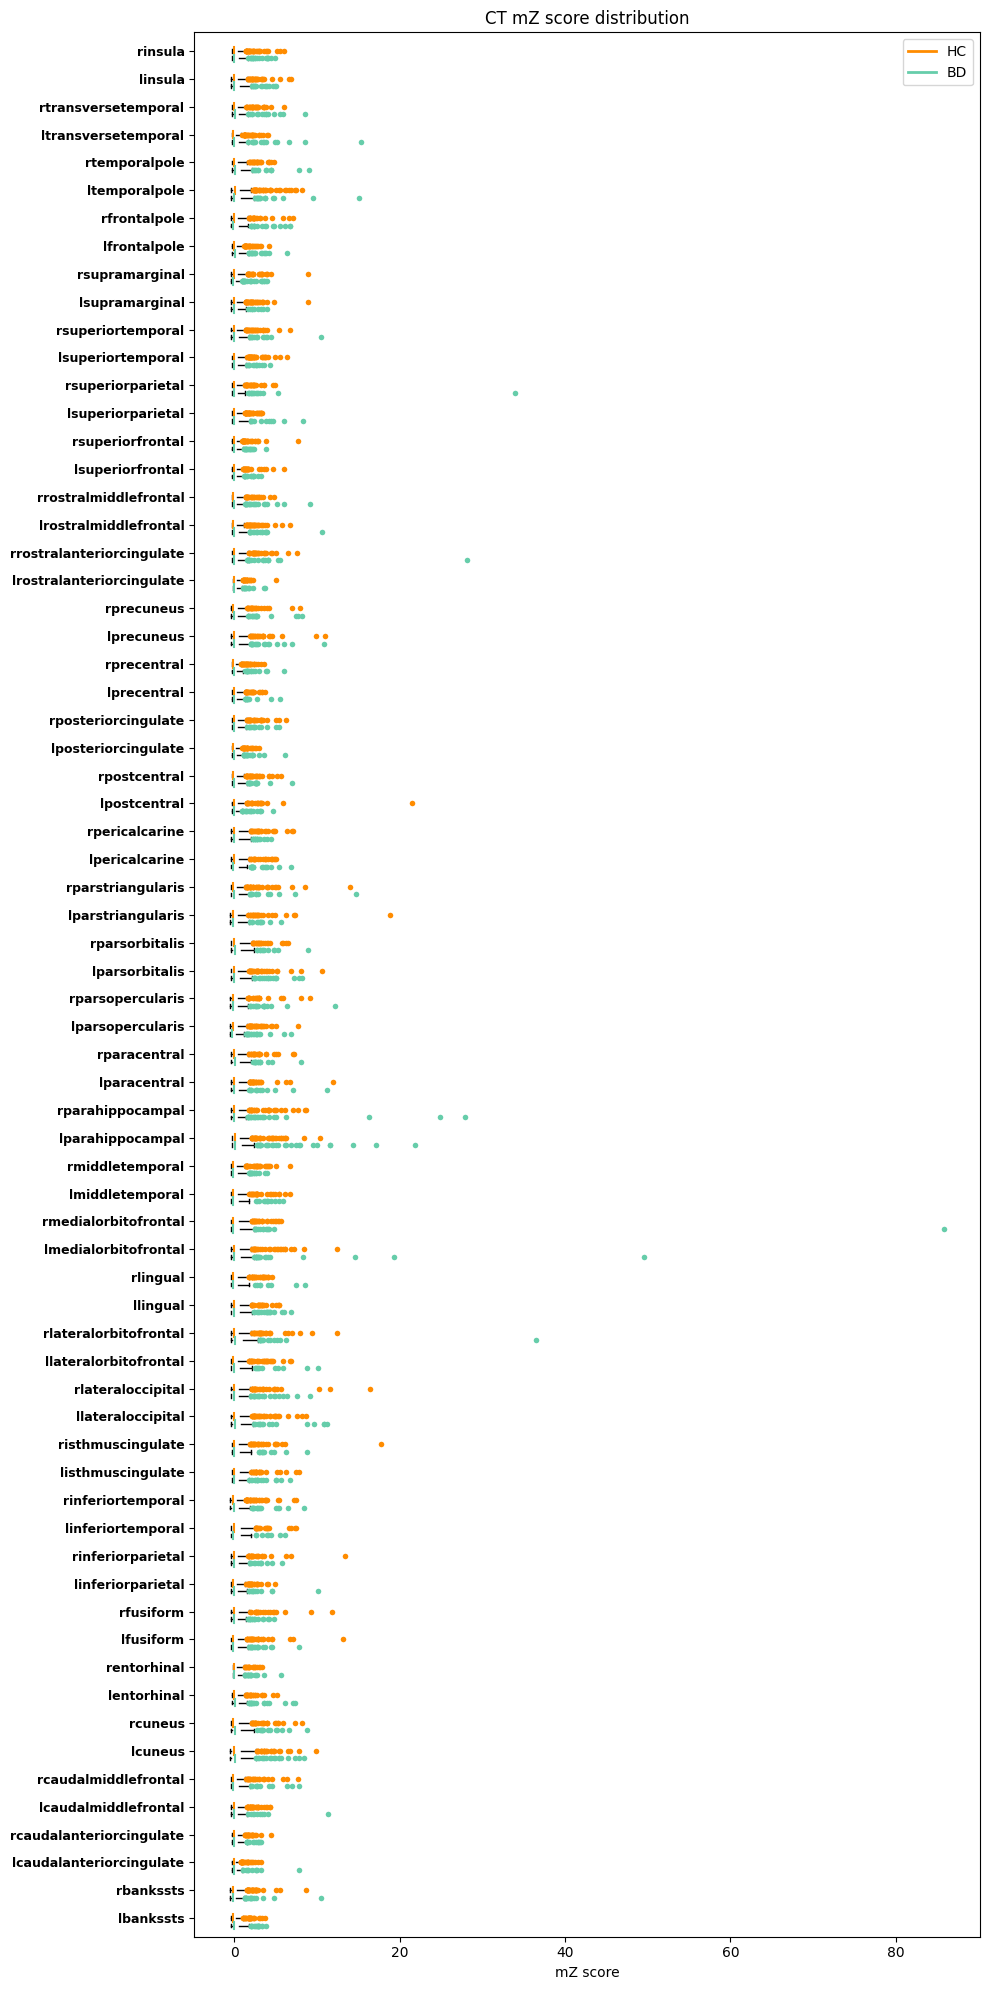

In [ ]:
from matplotlib.lines import Line2D

x = np.arange(0,170)  # y-coordinates for the features
ROI_names=atlas_ROI_names.loc[0:169,'Atlases_sorted'].values

plt.figure(figsize=(10,20))

HC_means=HC_RE_mzscore.mean().values
HC_CI=np.concatenate((HC_RE_mzscore.min().values.reshape(-1,1),HC_RE_mzscore.max().values.reshape(-1,1)),axis=1)


BD_means=BD_RE_mzscore.mean().values
BD_CI=np.concatenate((BD_RE_mzscore.min().values.reshape(-1,1),BD_RE_mzscore.max().values.reshape(-1,1)),axis=1)

x_spacing = np.array([15]*170)
x_group1 = x * x_spacing
x_group2 = x_group1 - np.array([4]*170)   # Adjust the spacing for the second group

#fig, ax=plt.subplots(2,1, figsize=(10,5))
flierprops = dict(marker='.', markerfacecolor='darkorange', markersize=8,
                  markeredgecolor='none')

medianprops = dict(linestyle='-', linewidth=1.5, color='darkorange')
plt.boxplot(HC_RE_mzscore.iloc[:,0:68], positions=x_group1[0:68], widths=4, vert= False, manage_ticks=True, showbox=False,
            flierprops= flierprops, medianprops=medianprops)

flierprops = dict(marker='.', markerfacecolor='mediumaquamarine', markersize=8,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=1.5, color='mediumaquamarine')
plt.boxplot(BD_RE_mzscore.iloc[:,0:68], vert= False,manage_ticks=True,  widths=4,positions=x_group2[0:68], showbox=False,
            flierprops= flierprops, medianprops=medianprops,patch_artist=False)


plt.yticks(x_group1[0:68],ROI_names[0:68], rotation=0, fontsize=9, fontweight='bold')
plt.ylim([-10,1015])

plt.xlabel('mZ score')
plt.title('CT mZ score distribution')

legend_elements = [
    Line2D([0], [0], color='darkorange', lw=2, label='HC'),
    Line2D([0], [0], color='mediumaquamarine', lw=2, label='BD')
]

# Set legends using the created legend handles
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

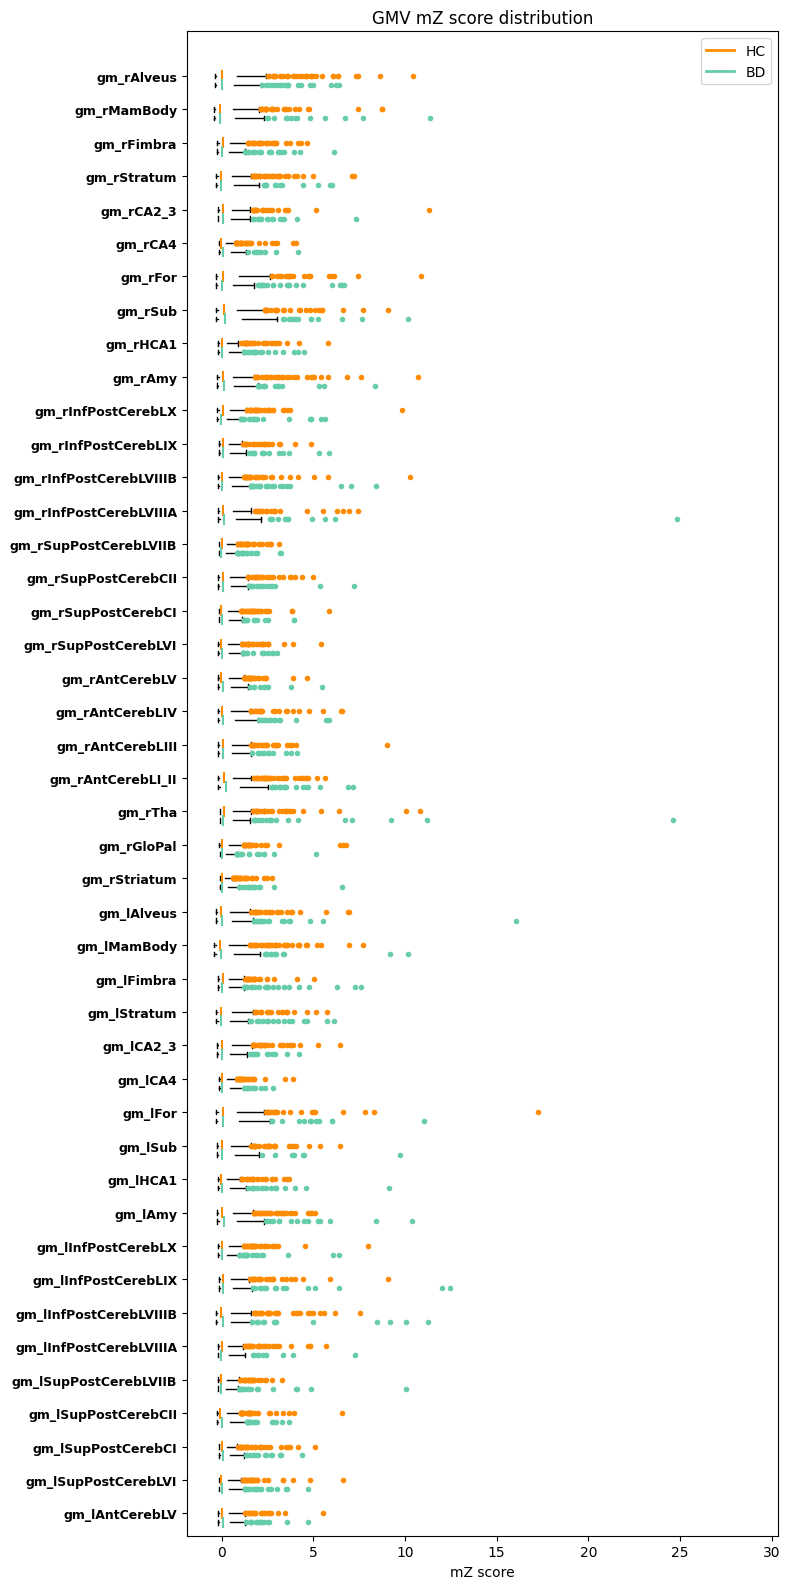

In [ ]:
x = np.arange(0,170)  # y-coordinates for the features
ROI_names=atlas_ROI_names_prefix.loc[0:169,'Atlases_sorted'].values

plt.figure(figsize=(8,16))

HC_means=HC_RE_mzscore.mean().values
HC_CI=np.concatenate((HC_RE_mzscore.min().values.reshape(-1,1),HC_RE_mzscore.max().values.reshape(-1,1)),axis=1)


BD_means=BD_RE_mzscore.mean().values
BD_CI=np.concatenate((BD_RE_mzscore.min().values.reshape(-1,1),BD_RE_mzscore.max().values.reshape(-1,1)),axis=1)

x_spacing = np.array([15]*170)
x_group1 = x * x_spacing
x_group2 = x_group1 - np.array([4]*170)   # Adjust the spacing for the second group

#fig, ax=plt.subplots(2,1, figsize=(10,5))
flierprops = dict(marker='.', markerfacecolor='darkorange', markersize=8,
                  markeredgecolor='none')

medianprops = dict(linestyle='-', linewidth=1.5, color='darkorange')
plt.boxplot(HC_RE_mzscore.iloc[:,68:118], positions=x_group1[68:118], widths=4, vert= False, manage_ticks=True, showbox=False,
            flierprops= flierprops, medianprops=medianprops)

flierprops = dict(marker='.', markerfacecolor='mediumaquamarine', markersize=8,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=1.5, color='mediumaquamarine')
plt.boxplot(BD_RE_mzscore.iloc[:,68:118], vert= False,manage_ticks=True,  widths=4,positions=x_group2[68:118], showbox=False,
            flierprops= flierprops, medianprops=medianprops,patch_artist=False)


plt.yticks(x_group1[68:118],ROI_names[68:118], rotation=0, fontsize=9, fontweight='bold')
plt.ylim([1100,1775])

plt.xlabel('mZ score')
plt.title('GMV mZ score distribution')

legend_elements = [
    Line2D([0], [0], color='darkorange', lw=2, label='HC'),
    Line2D([0], [0], color='mediumaquamarine', lw=2, label='BD')
]

# Set legends using the created legend handles
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

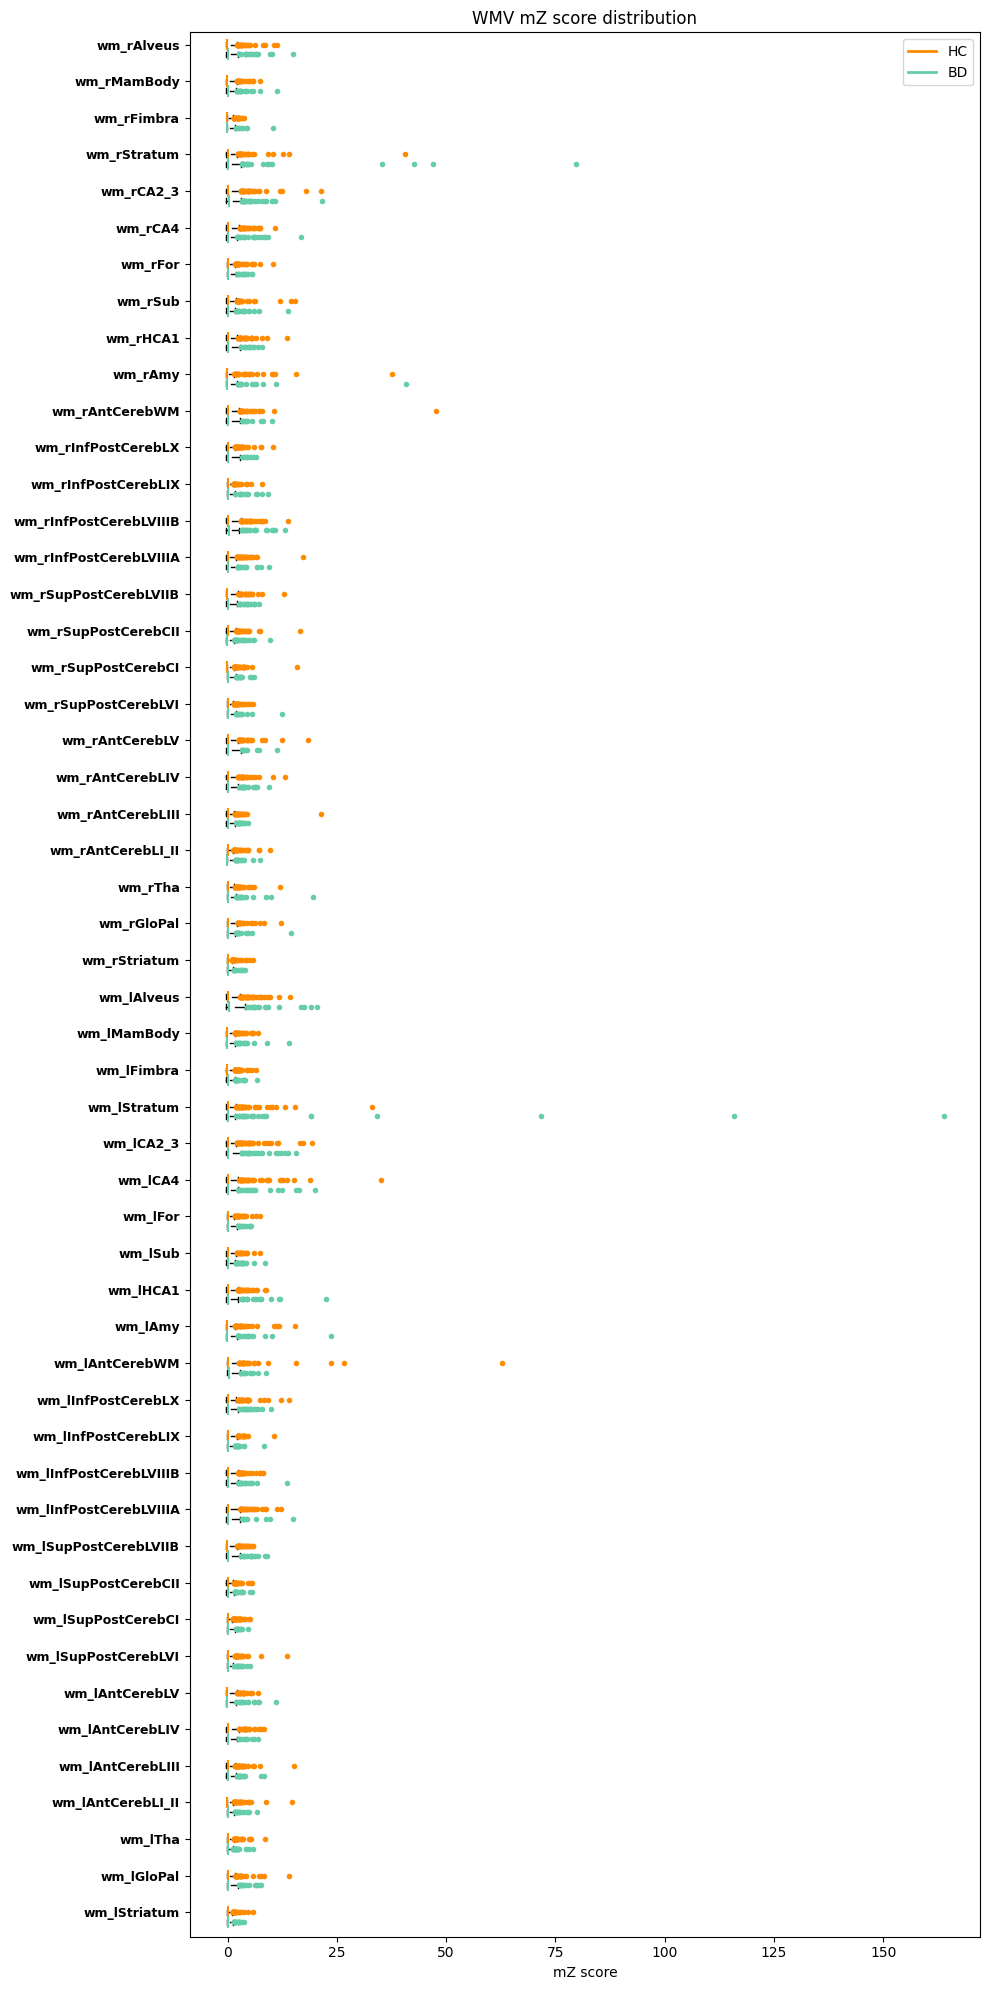

In [ ]:
x = np.arange(0,170)  # y-coordinates for the features
ROI_names=atlas_ROI_names_prefix.loc[0:169,'Atlases_sorted'].values

plt.figure(figsize=(10,20))

HC_means=HC_RE_mzscore.mean().values
HC_CI=np.concatenate((HC_RE_mzscore.min().values.reshape(-1,1),HC_RE_mzscore.max().values.reshape(-1,1)),axis=1)


BD_means=BD_RE_mzscore.mean().values
BD_CI=np.concatenate((BD_RE_mzscore.min().values.reshape(-1,1),BD_RE_mzscore.max().values.reshape(-1,1)),axis=1)

x_spacing = np.array([15]*170)
x_group1 = x * x_spacing
x_group2 = x_group1 - np.array([4]*170)   # Adjust the spacing for the second group

#fig, ax=plt.subplots(2,1, figsize=(10,5))
flierprops = dict(marker='.', markerfacecolor='darkorange', markersize=8,
                  markeredgecolor='none')

medianprops = dict(linestyle='-', linewidth=1.5, color='darkorange')
plt.boxplot(HC_RE_mzscore.iloc[:,118:170], positions=x_group1[118:170], widths=4, vert= False, manage_ticks=True, showbox=False,
            flierprops= flierprops, medianprops=medianprops)

flierprops = dict(marker='.', markerfacecolor='mediumaquamarine', markersize=8,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=1.5, color='mediumaquamarine')
plt.boxplot(BD_RE_mzscore.iloc[:,118:170], vert= False,manage_ticks=True,  widths=4,positions=x_group2[118:170], showbox=False,
            flierprops= flierprops, medianprops=medianprops,patch_artist=False)


plt.yticks(x_group1[118:170],ROI_names[118:170], rotation=0, fontsize=9, fontweight='bold')
plt.ylim([1760,2540])

plt.xlabel('mZ score')
plt.title('WMV mZ score distribution')

legend_elements = [
    Line2D([0], [0], color='darkorange', lw=2, label='HC'),
    Line2D([0], [0], color='mediumaquamarine', lw=2, label='BD')
]

# Set legends using the created legend handles
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## Finding specific 99th perc threshold

In [8]:
mZ_99perc_thr= []
n_feat=170
for i in range(n_feat):
  mZ_99perc_thr.append(HCP_RE_mzscore.iloc[:,i].quantile(0.99))

In [ ]:
# Melt the DataFrame for seaborn
df_melted = pd.melt(HCP_RE_mzscore, value_vars=HCP_RE_mzscore.columns, var_name="Feature")

# Create a mapping Series from atlas_ROI_names_prefix
feature_mapping = atlas_ROI_names_prefix.loc[:, 'Atlases_sorted']

# Add a new column 'FeatureName' to df_merge using the map function
df_melted['FeatureName'] = df_melted['Feature'].map(feature_mapping)

# Display the resulting DataFrame
df_melted

,Feature,value,FeatureName
0,0,-0.248890,lbankssts
1,0,-0.370017,lbankssts
2,0,-0.320325,lbankssts
3,0,-0.188902,lbankssts
4,0,-0.316879,lbankssts
...,...,...,...
188525,169,0.806075,wm_rAlveus
188526,169,2.012399,wm_rAlveus
188527,169,0.418418,wm_rAlveus
188528,169,1.266319,wm_rAlveus


In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#feat=165


# Create the data


df =  df_melted.copy()

# Calculate the 95th percentile for each feature
percentiles_95 = df['value'].apply(lambda col: np.percentile(col, 95))


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="FeatureName", hue="FeatureName", aspect=15, height=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value",
      bw_adjust=.3, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.3)

#g.map(plt.axvline, x=percentiles_95, color='r', linestyle='dashed', linewidth=1)

# Custom plotting function
def plot_threshold(data, color, **kwargs):
    threshold_value = np.percentile(data, 95)

    # Plot histogram with color from threshold to end
    #plt.axvline(x=threshold_value, color='r', linestyle='dashed', linewidth=1)
    plt.text(threshold_value, 0, '|', color='r', va='bottom', ha='center', fontweight="bold")


# Apply the custom plotting function to each subplot
g.map(plot_threshold, "value")

# Annotate the threshold value on each subplot
def annotate_threshold(col, **kwargs):
    ax = plt.gca()
    threshold_value = np.percentile(col, 95)
    ax.annotate(f'Threshold: {threshold_value:.2f}', xy=(threshold_value, 0),
                xytext=(5, 5), textcoords='offset points', color='r', ha='left',
                va='bottom', fontweight="bold", fontsize=12)

g.map(annotate_threshold, "value")

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="right", va="top", fontsize=15, transform=ax.transAxes)

g.map(label, "FeatureName")
g.set(xlim=(None,20))

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.75, top=0.5)

# Manually adjust the position of the subplots to create more space before the start of the histograms
for ax in g.axes.flat:
    ax.set_position([ax.get_position().x0 , ax.get_position().y0, ax.get_position().width, ax.get_position().height])


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Output hidden; open in https://colab.research.google.com to view.

# Ploting individual brain maps

In [9]:
!pip install abagen
!pip install nibabel

import abagen
import nibabel as nib

from nilearn import plotting, datasets, surface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 16.0 MB/s eta 0:00:00


In [10]:
import matplotlib
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)



In [12]:
from matplotlib.colors import ListedColormap

light_jet = cmap_map(lambda x: x/1.5 + 0.5, matplotlib.cm.jet)
dark_jet = cmap_map(lambda x: x*0.75, matplotlib.cm.jet)
#dark_jet = cmap_map(lambda x: x*0.80, matplotlib.cm.Spectral_r)

# Get the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')

# Define the segment you want (e.g., from green to red)
start_color = cmap_jet(0.2)  # Green
end_color = cmap_jet(1)    # Red

# Create a custom colormap using only the selected segment
custom_cmap = ListedColormap(dark_jet(np.linspace(0.5, 1, 256)))
custom_cmap = ListedColormap(dark_jet(np.linspace(0.5, 1, 256)))
#custom_cmap = ListedColormap(dark_jet(np.linspace(0.15, 1, 256)))


<ipython-input-12-dbfb3c7145f9>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_jet = plt.cm.get_cmap('jet')


In [ ]:
"""
# Import CMasher to register colormaps
#!pip install cmasher
import cmasher as cmr
cmr_cmap = cmr.neon_r
custom_cmap = ListedColormap(cmr_cmap(np.linspace(0.18, 1, 256)))
"""

In [13]:

!pip install colorcet
import colorcet as cc
cc_cmap=cc.cm.CET_CBTL1_r

cc_cmap = cmap_map(lambda x: x*0.95, cc.cm.CET_CBTL1_r)
custom_cmap = ListedColormap(cc_cmap(np.linspace(0.2, 1, 256)))


Plotting individual brain maps

In [14]:
# Load the NIfTI image

nifti_file = '/content/drive/MyDrive/PhD/atlases_files/cobra.nii'
cobra = nib.load(nifti_file)



In [15]:
cobra_ids=np.unique(cobra.get_fdata())
cobra_ids=np.delete(cobra_ids,[0]) #[16,41]
cobra_ids_gm=np.delete(cobra_ids,[16,41]) #[16,41]
#23 and 123 are WM

**Healthy controls -GMV**

In [71]:
gmv_regions=atlas_ROI_names[atlas_ROI_names['cobra_vgm']==1][['Atlases_sorted']]
gmv_regions['id']=cobra_ids_gm
gmv_regions

,Atlases_sorted,id
68,lStriatum,1.0
69,lGloPal,2.0
70,lTha,3.0
71,lAntCerebLI_II,11.0
72,lAntCerebLIII,12.0
73,lAntCerebLIV,13.0
74,lAntCerebLV,14.0
75,lSupPostCerebLVI,15.0
76,lSupPostCerebCI,16.0
77,lSupPostCerebCII,17.0


In [31]:
gmv_regions.loc[:, ('mZ')] = HC_RE_mzscore.loc[0,68:117].values

In [32]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in gmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = gmv_regions[gmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



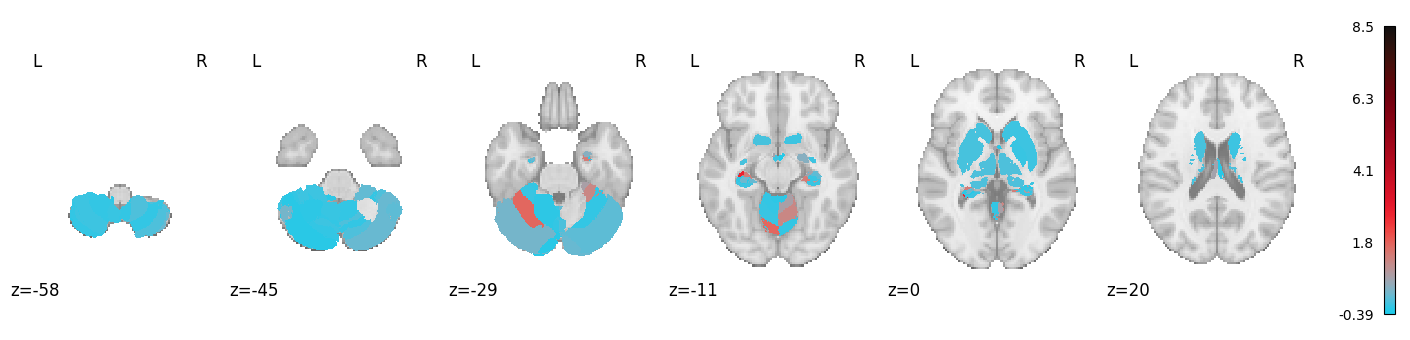

In [33]:
#custom_cmap
plotting.plot_stat_map(assigned_img, display_mode='z', vmax=8.5,draw_cross=False,
                       cmap=custom_cmap,symmetric_cbar=False, colorbar=True,
                       cut_coords=(-58,-45,-29,-11,0,20))
plotting.show()

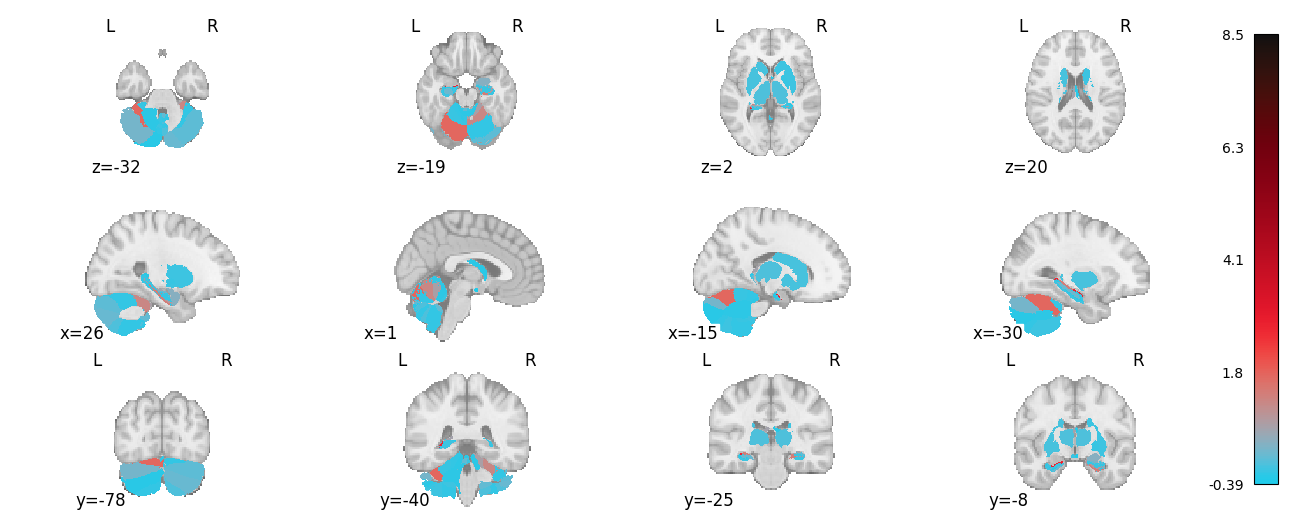

In [23]:
#custom_cmap
plotting.plot_stat_map(assigned_img, display_mode='mosaic', vmax=8.5,draw_cross=False,
                       cmap=custom_cmap,symmetric_cbar=False, colorbar=True,
                       cut_coords=4)
plotting.show()

**Bipolar Disorder -GMV**

In [24]:
gmv_regions.loc[:, ('mZ')] = BD_RE_mzscore.loc[11,68:117].values


In [25]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in gmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = gmv_regions[gmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



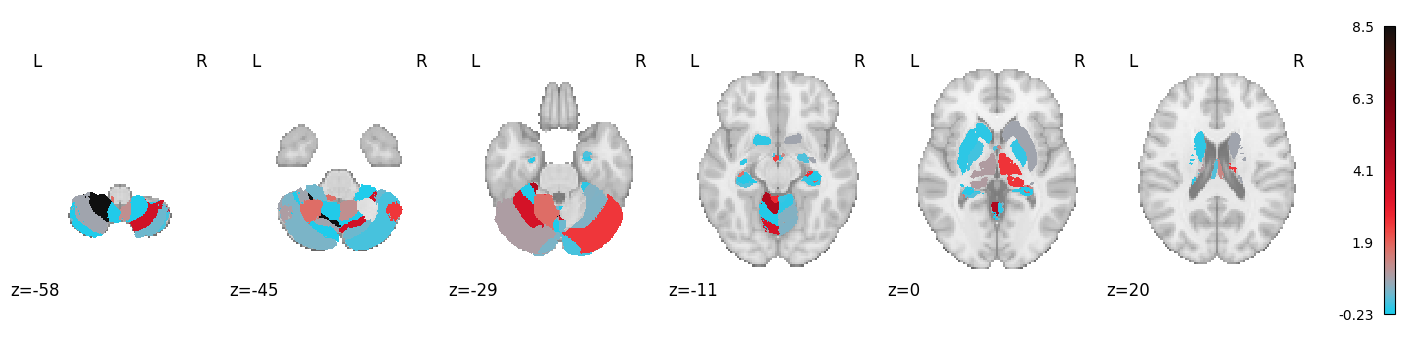

In [30]:
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cmap=custom_cmap, symmetric_cbar=False, colorbar=True,
                       cut_coords=(-58,-45,-29,-11,0,20))
#plotting.plot_roi(assigned_img, cmap='viridis_r', colorbar=True, vmin=-0.40, vmax=3)

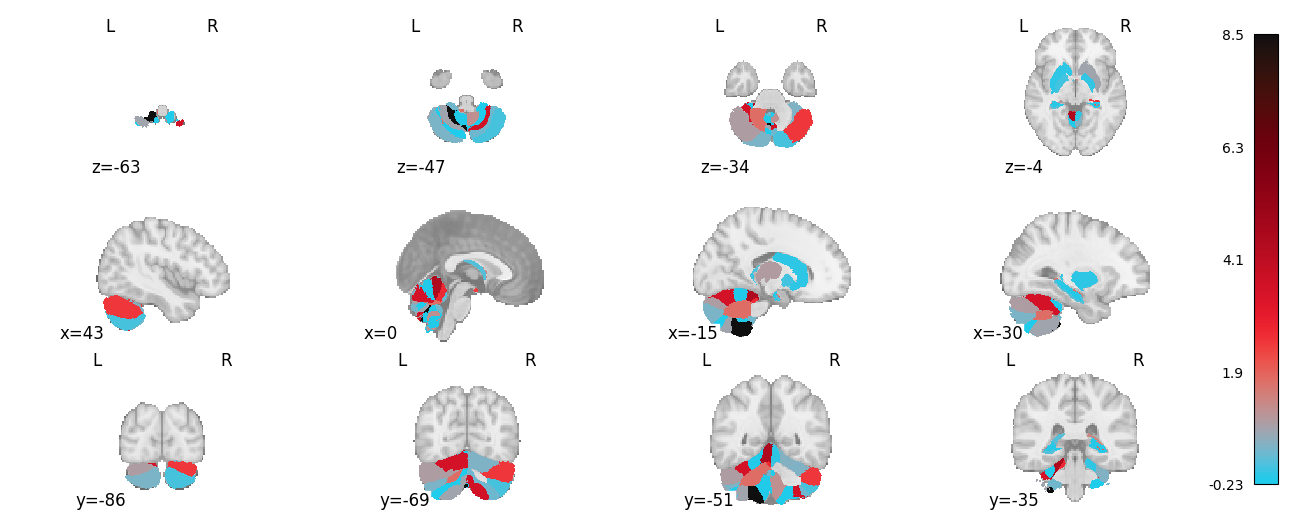

In [26]:
plotting.plot_stat_map(assigned_img, display_mode='mosaic', draw_cross=False,
                       cmap=custom_cmap, symmetric_cbar=False, colorbar=True, cut_coords=4)

**Healthy Controls -WMV**

In [72]:
wmv_regions=atlas_ROI_names[atlas_ROI_names['cobra_vwm']==1][['Atlases_sorted']]
wmv_regions['id']=cobra_ids
wmv_regions

,Atlases_sorted,id
118,lStriatum,1.0
119,lGloPal,2.0
120,lTha,3.0
121,lAntCerebLI_II,11.0
122,lAntCerebLIII,12.0
123,lAntCerebLIV,13.0
124,lAntCerebLV,14.0
125,lSupPostCerebLVI,15.0
126,lSupPostCerebCI,16.0
127,lSupPostCerebCII,17.0


In [35]:
wmv_regions.loc[:, ('mZ')] = HC_RE_mzscore.loc[0,118:169].values


In [36]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in wmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = wmv_regions[wmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



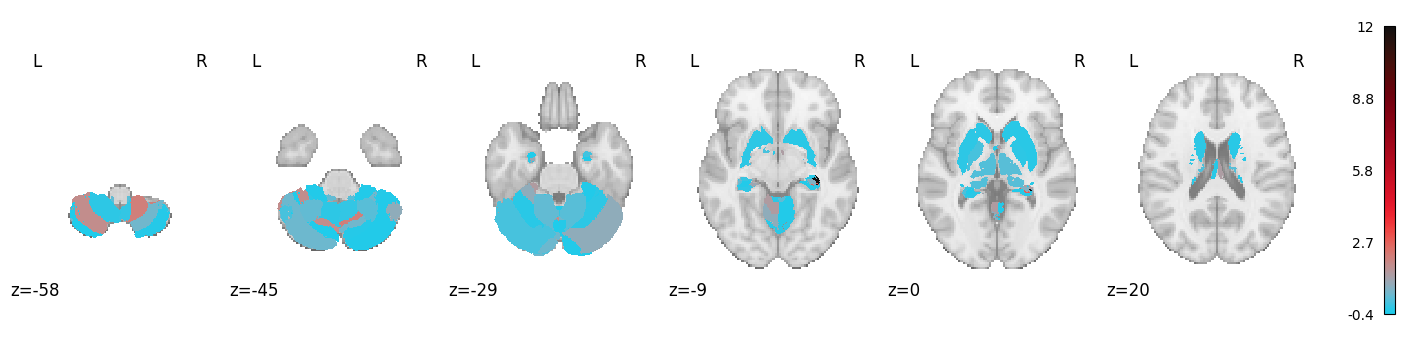

In [37]:
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cmap=custom_cmap, symmetric_cbar=False,colorbar=True,
                       cut_coords=(-58,-45,-29,-9,0,20)) #-11


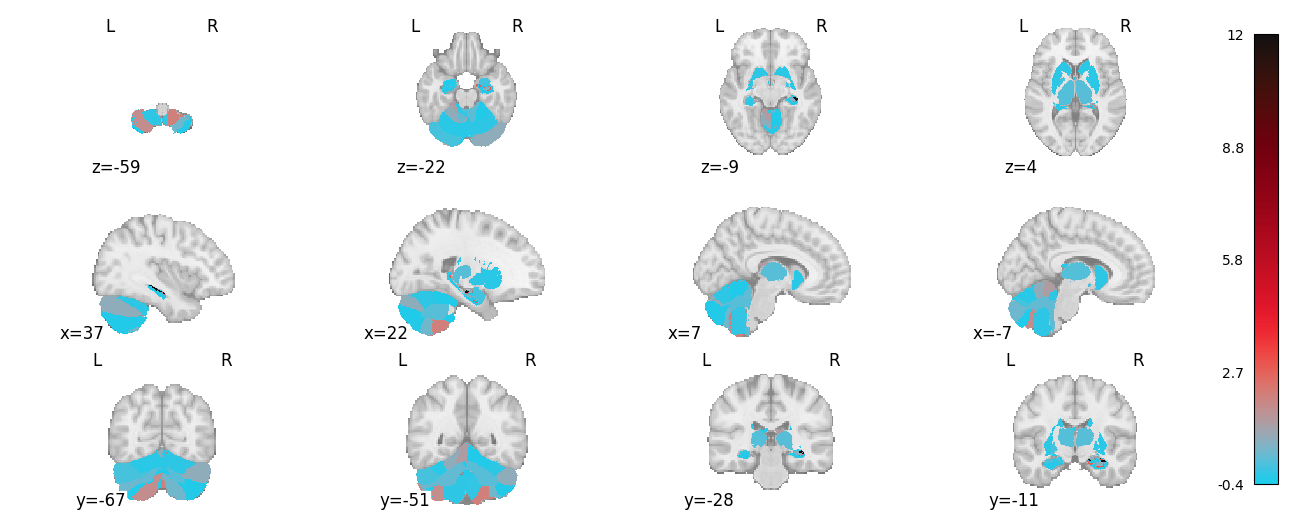

In [38]:
plotting.plot_stat_map(assigned_img, display_mode='mosaic', draw_cross=False,
                       cmap=custom_cmap, symmetric_cbar=False,colorbar=True, cut_coords=4)

**Bipolar Disoder - WMV**

In [75]:
wmv_regions.loc[:, ('mZ')] = BD_RE_mzscore.loc[11,118:169].values


In [76]:
wmv_regions[['mZ']].max()

mZ    12.456851
dtype: float64

In [77]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in wmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = wmv_regions[wmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



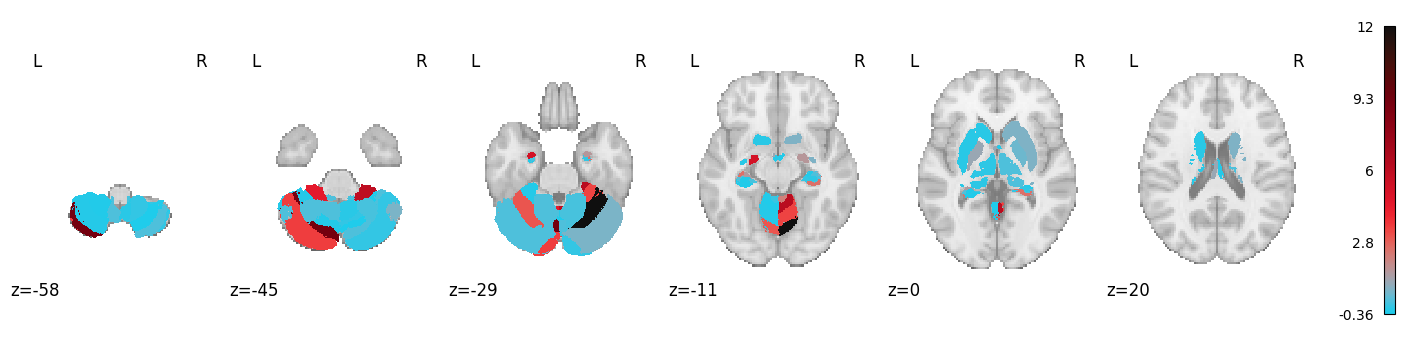

In [78]:
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                      cmap=custom_cmap, symmetric_cbar=False, colorbar=True,
                       cut_coords=(-58,-45,-29,-11,0,20))
#plotting.plot_roi(assigned_img, cmap=''PRGn'', colorbar=True, vmin=-0.40, vmax=3)

In [83]:
np.where(BD_RE_mzscore.loc[11,118:169].values>5)

(array([10, 16, 29, 31, 33, 40]),)

In [82]:
wmv_regions.iloc[33,:]

Atlases_sorted    rSupPostCerebLVI
id                           115.0
mZ                       12.456851
Name: 151, dtype: object

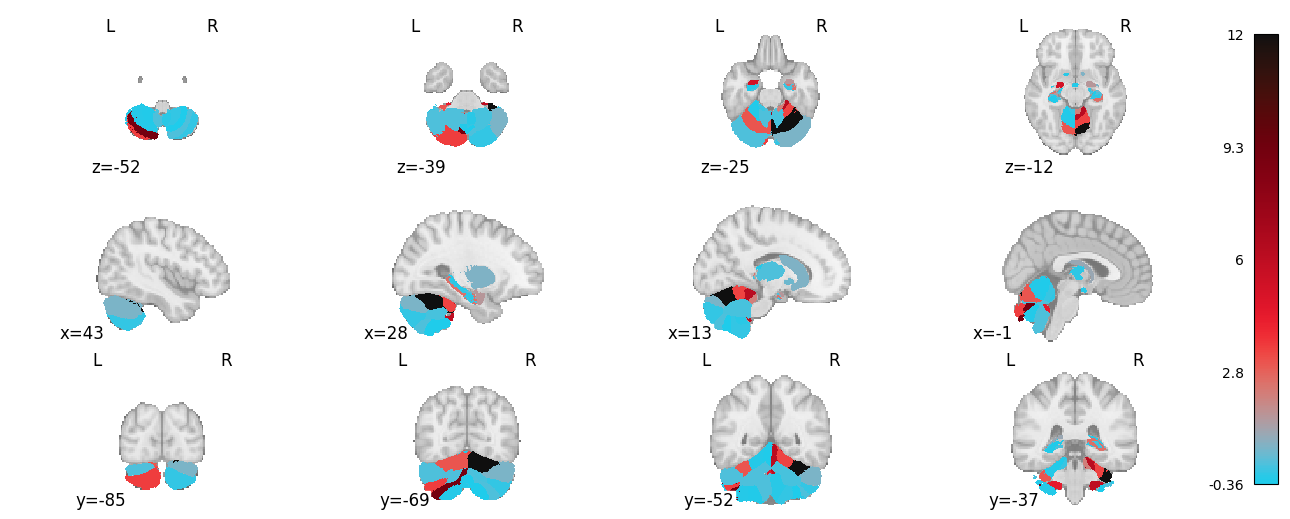

In [79]:
plotting.plot_stat_map(assigned_img, display_mode='mosaic', draw_cross=False,
                       cmap=custom_cmap, symmetric_cbar=False,colorbar=True, cut_coords=4)

# Abnormality frequencies %

In [84]:
# percentile abnormal features
# Put a one where is deviating
BD_perc_abnormal=pd.DataFrame(np.zeros((n_BD, n_feat)))
HC_perc_abnormal=pd.DataFrame(np.zeros((n_HC, n_feat)))
for i in range(n_feat):
  HC_perc_abnormal.iloc[np.where(HC_RE_mzscore.iloc[:,i]>mZ_99perc_thr[i])[0],i]=1
  BD_perc_abnormal.iloc[np.where(BD_RE_mzscore.iloc[:,i]>mZ_99perc_thr[i])[0],i]=1

### % abnormality by feature

In [ ]:
overlap_bd=np.sum(BD_perc_abnormal)/ len(BD_perc_abnormal)
overlap_bd

0      0.000000
1      0.005348
2      0.005348
3      0.000000
4      0.005348
         ...   
165    0.021390
166    0.032086
167    0.016043
168    0.010695
169    0.016043
Length: 170, dtype: float64

In [ ]:
np.mean(np.sum(BD_perc_abnormal, axis=1)/170)

0.019471531928279332

In [ ]:
np.sum(np.sum(BD_perc_abnormal, axis=1))/187

3.3101604278074865

In [ ]:
np.mean(np.sum(HC_perc_abnormal, axis=1)/170)

0.013061092205477232

In [ ]:
np.sum(np.sum(HC_perc_abnormal, axis=1))/len(HC_perc_abnormal)

2.2203856749311295

**Overlapping patterns**

In [ ]:
!pip install py_stringmatching
import py_stringmatching as psm

In [ ]:
bd_abn_feat=pd.DataFrame(np.zeros((n_BD, n_feat)))
hc_abn_feat=pd.DataFrame(np.zeros((n_HC, n_feat)))
for i in range(n_feat):
  hc_abn_feat.iloc[np.where(HC_RE_mzscore.iloc[:,i]>mZ_99perc_thr[i])[0],i]=i
  bd_abn_feat.iloc[np.where(BD_RE_mzscore.iloc[:,i]>mZ_99perc_thr[i])[0],i]=i


In [ ]:

pairs_hc_oc=[]
pairs_hc_jc=[]

for subj in range(0,len(hc_abn_feat)-1): # from 0 to -1
  for subj1 in range(subj+1,len(hc_abn_feat)): # from subj to final
    oc = psm.OverlapCoefficient()
    jc= psm.Jaccard()
    res1=oc.get_raw_score(list(hc_abn_feat.iloc[subj,:]), list(hc_abn_feat.iloc[subj1,:]))
    res2=jc.get_sim_score(list(hc_abn_feat.iloc[subj,:]), list(hc_abn_feat.iloc[subj1,:]))
    pairs_hc_oc.append(res1)
    pairs_hc_jc.append(res2)

In [ ]:
pairs_bd_oc=[]
pairs_bd_jc=[]

for subj in range(0,len(bd_abn_feat)-1): # from 0 to -1
  for subj1 in range(subj+1,len(bd_abn_feat)): # from subj to final
    oc = psm.OverlapCoefficient()
    jc= psm.Jaccard()
    res1=oc.get_raw_score(list(bd_abn_feat.iloc[subj,:]), list(bd_abn_feat.iloc[subj1,:]))
    res2=jc.get_sim_score(list(bd_abn_feat.iloc[subj,:]), list(bd_abn_feat.iloc[subj1,:]))
    pairs_bd_oc.append(res1)
    pairs_bd_jc.append(res2)

In [ ]:
pairs_dif_oc=[]
pairs_dif_jc=[]

for subj in range(0,len(hc_abn_feat)-1): # from 0 to -1
  for subj1 in range(0,len(bd_abn_feat)): # from subj to final
    oc = psm.OverlapCoefficient()
    jc= psm.Jaccard()
    res1=oc.get_raw_score(list(hc_abn_feat.iloc[subj,:]), list(bd_abn_feat.iloc[subj1,:]))
    res2=jc.get_sim_score(list(hc_abn_feat.iloc[subj,:]), list(bd_abn_feat.iloc[subj1,:]))
    pairs_dif_oc.append(res1)
    pairs_dif_jc.append(res2)

In [ ]:
np.mean(pairs_dif_jc)

0.26901681137214156

In [ ]:
np.mean(pairs_bd_jc)

0.22762046569002942

In [ ]:
np.mean(pairs_hc_jc)

0.32231143797967643

In [ ]:
np.mean(pairs_dif_oc)

0.6690999706996102

In [ ]:
np.mean(pairs_bd_oc)

0.5989715985241163

In [ ]:
np.mean(pairs_hc_oc)

0.7247653527206972

In [85]:
BD_abn_feat_map=(np.sum(BD_perc_abnormal,axis=0)/len(BD_perc_abnormal))*100

In [86]:
HC_abn_feat_map=(np.sum(HC_perc_abnormal,axis=0)/len(HC_perc_abnormal))*100

**HC overlapping deviating brain maps**

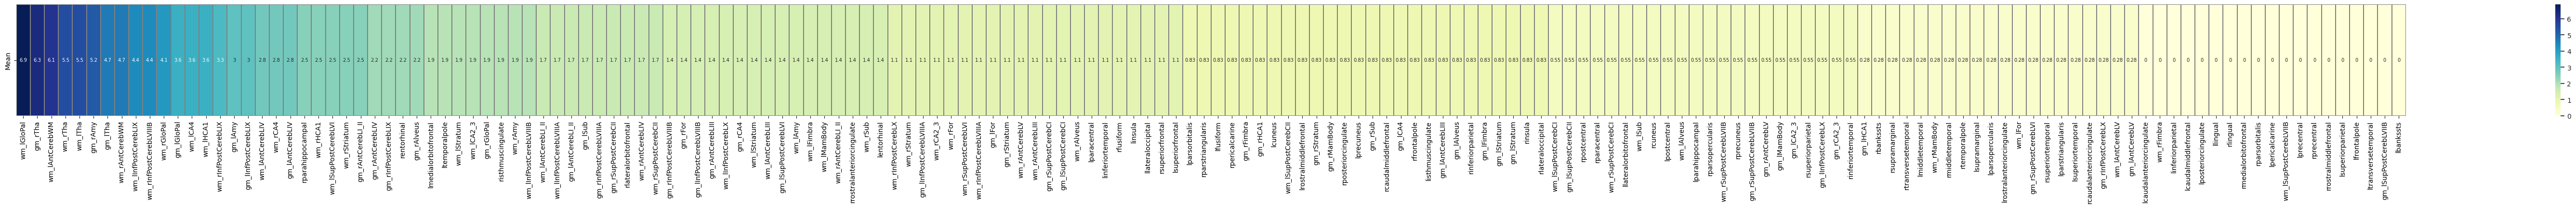

In [ ]:
overlap_perc_hc=pd.DataFrame(HC_abn_feat_map.values).transpose()

#fig, ax1 = plt.subplots( 2,1, figsize = (80,3)) # width x height
fig = plt.figure(figsize = (80,3)) # width x height
ax1 = fig.add_subplot(1, 1, 1) # row, column, position

overlap_perc_hc_sorted=overlap_perc_hc.sort_values(by=0, axis=1, ascending=False )

x_axis_labels = atlas_ROI_names_prefix.iloc[overlap_perc_hc_sorted.columns.astype(int),0].values# labels for x-axis
y_axis_labels = ["Mean"] # labels for y-axis4
sns.set(font_scale=0.6, )
heatmap1=sns.heatmap(overlap_perc_hc_sorted, annot=True, yticklabels=y_axis_labels, xticklabels=x_axis_labels, ax=ax1, cmap="YlGnBu", linewidths=0.1, linecolor='gray')

# Customize x-axis label font size
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)

# Customize colorbar font size
cbar = heatmap1.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.show()


**BD overlapping brain deviating maps**

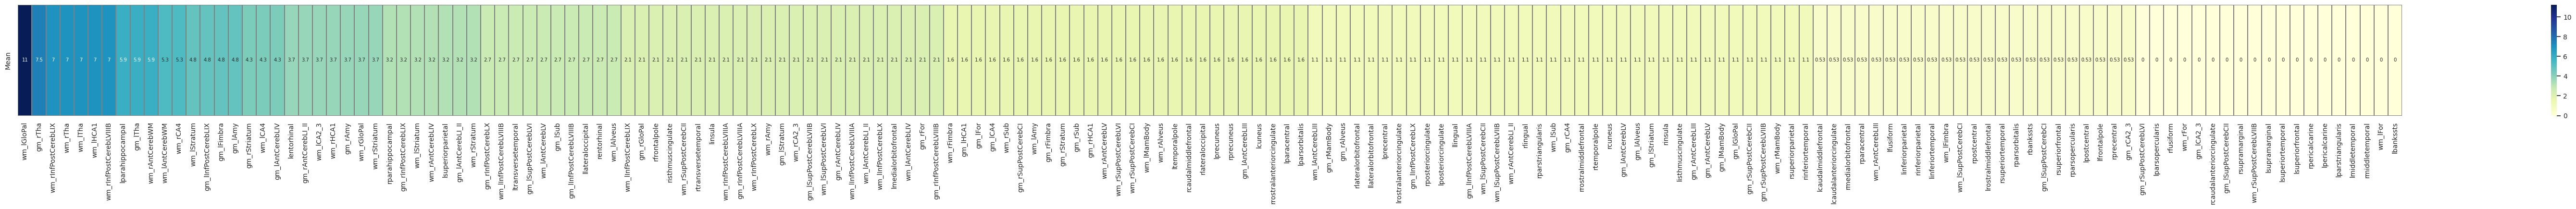

In [ ]:
overlap_perc_bd=pd.DataFrame(BD_abn_feat_map.values).transpose()

#fig, ax1 = plt.subplots( 2,1, figsize = (80,3)) # width x height
fig = plt.figure(figsize = (80,3)) # width x height
ax1 = fig.add_subplot(1, 1, 1) # row, column, position

overlap_perc_bd_sorted=overlap_perc_bd.sort_values(by=0, axis=1, ascending=False )

x_axis_labels = atlas_ROI_names_prefix.iloc[overlap_perc_bd_sorted.columns.astype(int),0].values# labels for x-axis
y_axis_labels = ["Mean"] # labels for y-axis4
sns.set(font_scale=0.6, )
heatmap1=sns.heatmap(overlap_perc_bd_sorted, annot=True, yticklabels=y_axis_labels, xticklabels=x_axis_labels, ax=ax1, cmap="YlGnBu", linewidths=0.1, linecolor='gray')

# Customize x-axis label font size
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)

# Customize colorbar font size
cbar = heatmap1.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.show()


In [88]:
!pip install cmasher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 8.4 MB/s eta 0:00:00


In [89]:
from matplotlib.colors import ListedColormap

#light_jet = cmap_map(lambda x: x/1.5 + 0.5, matplotlib.cm.jet)
dark = cmap_map(lambda x: x*0.75, matplotlib.cm.jet)

# Get the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')

# Define the segment you want (e.g., from green to red)
start_color = cmap_jet(0.2)  # Green
end_color = cmap_jet(1)    # Red

# Create a custom colormap using only the selected segment
custom_cmap = ListedColormap(dark(np.linspace(0.5, 1, 256)))


<ipython-input-89-ac45f3b66844>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_jet = plt.cm.get_cmap('jet')


In [108]:
# Import CMasher to register colormaps
import cmasher as cmr

#cmr_cmap = cmr.flamingo_r
#custom_cmap = ListedColormap(cmr_cmap(np.linspace(0.45, 1, 256)))

#matplotlib.cm.gist_heat

#dark = cmap_map(lambda x: x*0.85, matplotlib.cm.Reds)
custom_cmap = ListedColormap(matplotlib.cm.Reds(np.linspace(0.1, 1, 256))) # Reds or OrRd or gist_heat

**Healthy Control CT**

In [ ]:


atlas = abagen.fetch_desikan_killiany()
dk= nib.load(atlas['image'])

info = pd.read_csv(atlas['info'])
info_copy=info[info['structure']=='cortex'].copy()
median_pairs=[]

#lh
for i in range(0,68,2):
  median_pairs.append(HC_abn_feat_map.iloc[i])

info_copy.loc[0:34,('median')]=median_pairs


median_odds=[]

#rh
for i in range(1,68,2):
  median_odds.append(HC_abn_feat_map.iloc[i])

info_copy.loc[34:,('median')]=median_odds


In [ ]:
info_copy[['median']].max()

median    2.479339
dtype: float64

In [ ]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(dk.get_fdata())

for roi_id in info_copy.id.values:
  roi_indices=np.where(dk.get_fdata() == roi_id)

  assigned_values[roi_indices] = info_copy[info_copy['id']==roi_id][['median']].values
assigned_CT = nib.Nifti1Image(assigned_values, dk.affine, dk.header)



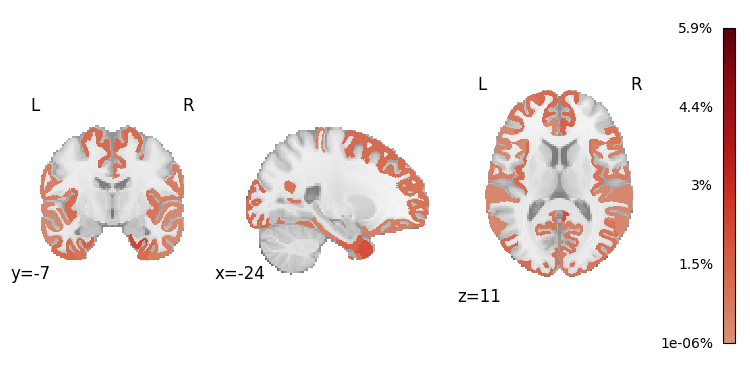

In [ ]:
#custom_cmap
#copper_r
plotting.plot_stat_map(assigned_CT,  cmap=custom_cmap, vmax=5.9,
                       draw_cross=False, cbar_tick_format="%.2g%%",
                       display_mode='ortho') #'ortho'

**Bipolar Disoder CT**

In [ ]:


atlas = abagen.fetch_desikan_killiany()
dk= nib.load(atlas['image'])

info = pd.read_csv(atlas['info'])
info_copy=info[info['structure']=='cortex'].copy()
median_pairs=[]

#lh
for i in range(0,68,2):
  median_pairs.append(BD_abn_feat_map.iloc[i])

info_copy.loc[0:34,('median')]=median_pairs


median_odds=[]

#rh
for i in range(1,68,2):
  median_odds.append(BD_abn_feat_map.iloc[i])

info_copy.loc[34:,('median')]=median_odds


In [ ]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(dk.get_fdata())

for roi_id in info_copy.id.values:
  roi_indices=np.where(dk.get_fdata() == roi_id)

  assigned_values[roi_indices] = info_copy[info_copy['id']==roi_id][['median']].values
assigned_CT = nib.Nifti1Image(assigned_values, dk.affine, dk.header)


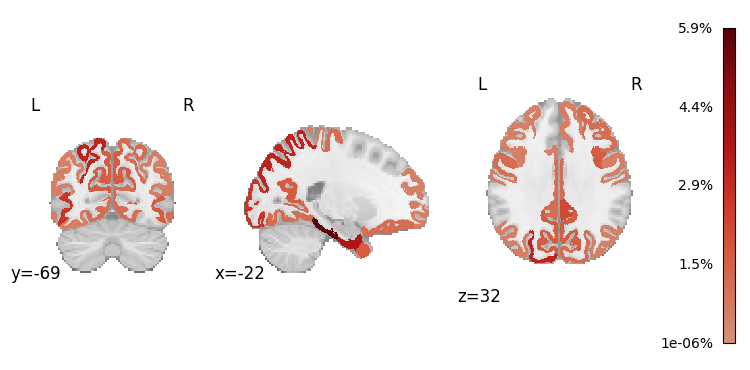

In [ ]:

plotting.plot_stat_map(assigned_CT,  cmap=custom_cmap, cbar_tick_format="%.2g%%",
                       draw_cross=False,display_mode='ortho') #display_mode='ortho', cut_coords=(-25, -20, -10)

#display_mode='x', cut_coords=(-40, -30, -15, 20, 25, 30)

In [91]:
 # Load the NIfTI image
nifti_file = '/content/drive/MyDrive/PhD/atlases_files/cobra.nii'
cobra = nib.load(nifti_file)



In [92]:
cobra_ids=np.unique(cobra.get_fdata())
cobra_ids=np.delete(cobra_ids,[0]) #[16,41]
cobra_ids_gm=np.delete(cobra_ids,[16,41]) #[16,41]
#23 and 123 are WM

In [93]:
gmv_regions=atlas_ROI_names[atlas_ROI_names['cobra_vgm']==1][['Atlases_sorted']]
gmv_regions['id']=cobra_ids_gm
#gmv_regions

**Healthy Control GMV**

In [103]:
gmv_regions.loc[:, ('mZ')] = HC_abn_feat_map.loc[68:117].values

In [104]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in gmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = gmv_regions[gmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



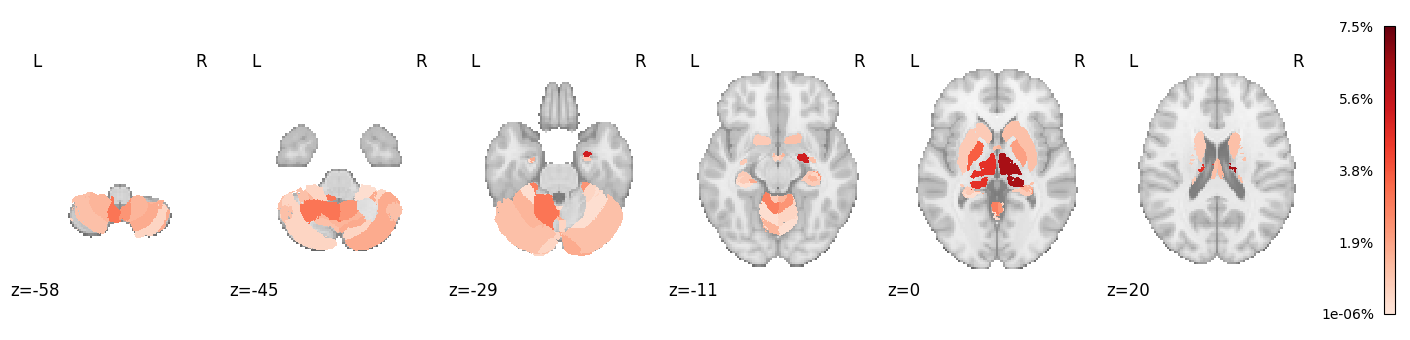

In [109]:
# TODO
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cbar_tick_format="%.2g%%",
                       cmap=custom_cmap, vmax=7.5, symmetric_cbar=False,
                       colorbar=True, cut_coords=(-58,-45,-29,-11,0,20))
plotting.show()
#plotting.plot_stat_map(assigned_WMV,  cmap='Reds', display_mode='mosaic',
#                       threshold= -np.log10(0.01),draw_cross=False)

#plotting.plot_roi(assigned_img, cmap='viridis_r', colorbar=True, vmin=-0.40, vmax=3)

**BD GMV**

In [110]:
gmv_regions.loc[:, ('mZ')] = BD_abn_feat_map.loc[68:117].values

In [111]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in gmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = gmv_regions[gmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



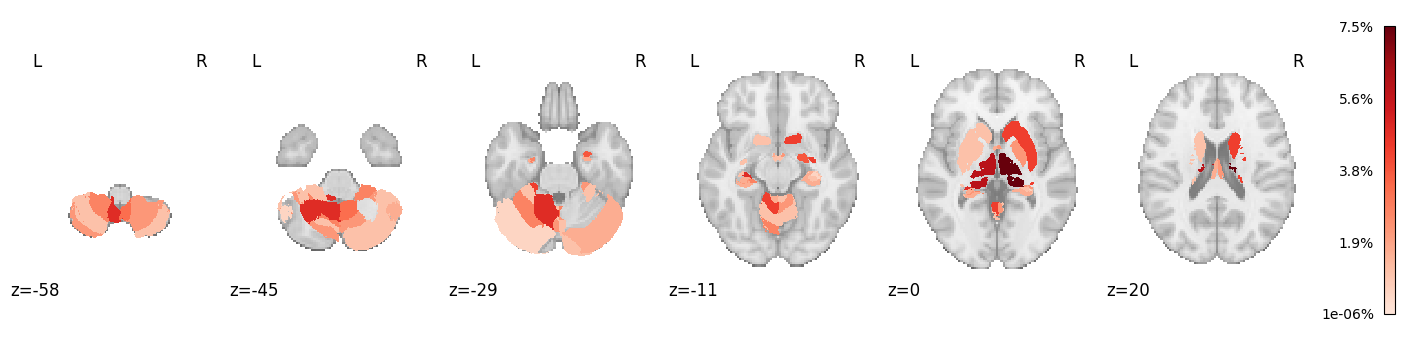

In [112]:
# TODO
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cbar_tick_format="%.2g%%",
                       cmap=custom_cmap, vmax=7.5, symmetric_cbar=False,
                       colorbar=True, cut_coords=(-58,-45,-29,-11,0,20))
plotting.show()
#plotting.plot_stat_map(assigned_WMV,  cmap='Reds', display_mode='mosaic',
#                       threshold= -np.log10(0.01),draw_cross=False)

#plotting.plot_roi(assigned_img, cmap='viridis_r', colorbar=True, vmin=-0.40, vmax=3)

**HC WMV**

In [113]:
wmv_regions=atlas_ROI_names[atlas_ROI_names['cobra_vwm']==1][['Atlases_sorted']]
wmv_regions['id']=cobra_ids
wmv_regions

,Atlases_sorted,id
118,lStriatum,1.0
119,lGloPal,2.0
120,lTha,3.0
121,lAntCerebLI_II,11.0
122,lAntCerebLIII,12.0
123,lAntCerebLIV,13.0
124,lAntCerebLV,14.0
125,lSupPostCerebLVI,15.0
126,lSupPostCerebCI,16.0
127,lSupPostCerebCII,17.0


In [118]:
wmv_regions.loc[:, ('mZ')] = HC_abn_feat_map.loc[118:169].values

In [115]:
wmv_regions

,Atlases_sorted,id,mZ
118,lStriatum,1.0,3.208556
119,lGloPal,2.0,11.229947
120,lTha,3.0,6.951872
121,lAntCerebLI_II,11.0,2.139037
122,lAntCerebLIII,12.0,1.069519
123,lAntCerebLIV,13.0,2.139037
124,lAntCerebLV,14.0,2.673797
125,lSupPostCerebLVI,15.0,2.139037
126,lSupPostCerebCI,16.0,0.534759
127,lSupPostCerebCII,17.0,1.069519


In [119]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in wmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = wmv_regions[wmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



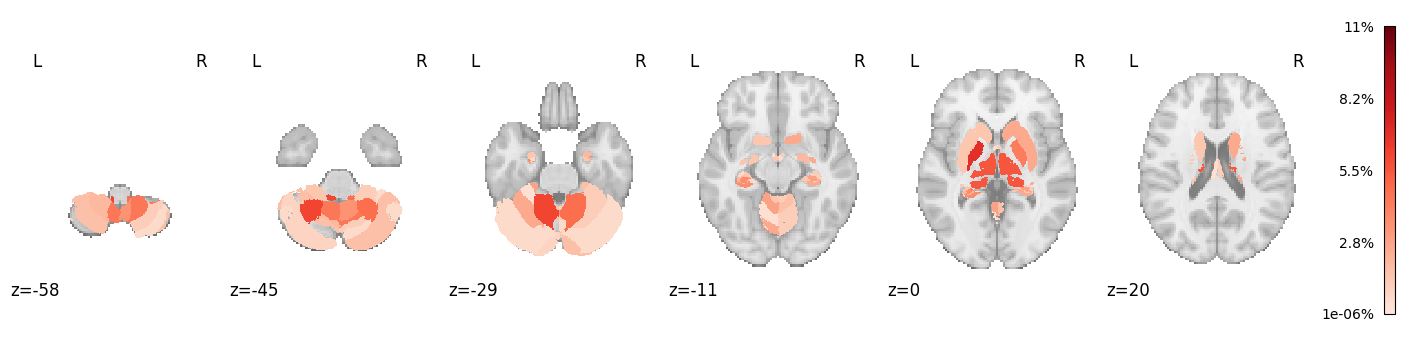

In [120]:
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cbar_tick_format="%.2g%%",
                       cmap=custom_cmap, vmax=11.0, symmetric_cbar=False,
                       colorbar=True, cut_coords=(-58,-45,-29,-11,0,20))
#
#plotting.plot_roi(assigned_img, cmap='viridis_r', colorbar=True, vmin=-0.40, vmax=3)

**BD WMV**

In [121]:
wmv_regions.loc[:, ('mZ')] = BD_abn_feat_map.loc[118:169].values

In [122]:
# Extract unique labels from the image data

assigned_values = np.zeros_like(cobra.get_fdata())

for roi_id in wmv_regions.id.values:
  roi_indices=np.where(cobra.get_fdata() == roi_id)

  assigned_values[roi_indices] = wmv_regions[wmv_regions['id']==roi_id][['mZ']].values
assigned_img = nib.Nifti1Image(assigned_values, cobra.affine, cobra.header)



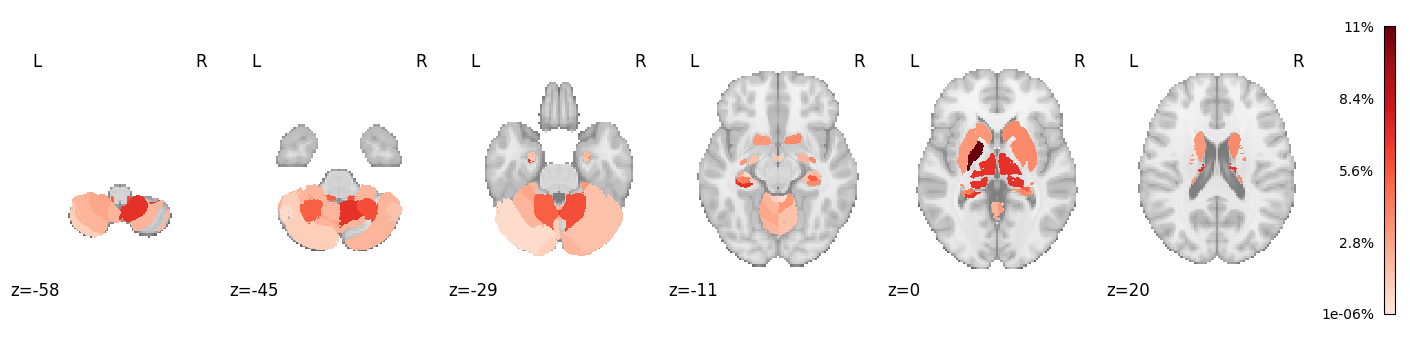

In [123]:
plotting.plot_stat_map(assigned_img, display_mode='z', draw_cross=False,
                       cbar_tick_format="%.2g%%",
                       cmap=custom_cmap, symmetric_cbar=False,colorbar=True,
                       cut_coords= (-58,-45,-29,-11,0,20))
#
#plotting.plot_roi(assigned_img, cmap='viridis_r', colorbar=True, vmin=-0.40, vmax=3)